In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pathlib
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import BisectingKMeans
import matplotlib.pyplot as plt

from src.analysis.cluster_data import cluster_data
from src.analysis.preprocess_data import preprocess_data
from src.utils.analysis_utils import get_features_contribution
from src.utils.spotify_utils import categories_songs, create_playlist_name
from src.service.spotify_api import SpotifyApi

In [3]:
# plt.style.use("dark_background")

In [4]:
# set seed for reproducibility
seed = 123

In [5]:
audio_df = pd.read_csv('./data/df_audio_features_5000.csv', index_col=0)
audio_df.head()

name                                                                                                                                                                               \
0  Se Eu Quiser Falar Com Deus                   ...                                                                                                                                  
1  Saudade De Bahia                              ...                                                                                                                                  
2  Canta Canta, Minha Gente                      ...                                                                                                                                  
3  Mulher Eu Sei                                 ...                                                                                                                                  
4  Rosa Morena                                   ...                                                                                                                                  

   artist                                            danceability   energy     \
0  Gilberto Gil                                              0.658     0.2590   
1  Antônio Carlos Jobim                                      0.742     0.3990   
2  Martinho Da Vila                                          0.851     0.7300   
3  Chico César                                               0.705     0.0502   
4  Kurt Elling                                               0.651     0.1190   

   key   loudness   mode   speechiness   acousticness   instrumentalness   \
0    11    -13.141      0        0.0705          0.694           0.000059   
1     2    -12.646      1        0.0346          0.217           0.000002   
2     2    -11.048      1        0.3470          0.453           0.000063   
3     4    -18.115      1        0.0471          0.879           0.000041   
4     6    -19.807      1        0.0380          0.916           0.000343   

   liveness   valence   tempo     type   duration_ms   time_signature   \
0      0.975     0.306   110.376               256213                4   
1      0.107     0.693   125.039               191867                4   
2      0.124     0.905    93.698               152267                4   
3      0.386     0.524   106.802               186227                4   
4      0.104     0.402   120.941               273680                4   

   id                                                                    html  
0  1n7JnwviZ7zf0LR1tcGFq7   https://open.spotify.com/track/1n7JnwviZ7zf0LR...  
1  5QGM1U0eCYrQuwSJwTm5Zq   https://open.spotify.com/track/5QGM1U0eCYrQuwS...  
2  0NLIFSZxPzQhCwnkn5PJYs   https://open.spotify.com/track/0NLIFSZxPzQhCwn...  
3  3mXqOdlLE1k67WsAxryPFs   https://open.spotify.com/track/3mXqOdlLE1k67Ws...  
4  7bSzjzjTkWT2CkIPPdp0eA   https://open.spotify.com/track/7bSzjzjTkWT2CkI...

Two columns, id and html we don't need for our analysis. Furthermore the .csv was probably saved with index on resulting in "unnamed: 0" column.
Let's start with cleaning the columns

In [6]:
# check column naming
audio_df.columns

Index(['name                                                                                                                                                                             ',
       'artist                                          ', 'danceability ',
       'energy   ', 'key ', 'loudness ', 'mode ', 'speechiness ',
       'acousticness ', 'instrumentalness ', 'liveness ', 'valence ',
       'tempo   ', 'type ', 'duration_ms ', 'time_signature ',
       'id                     ', 'html'],
      dtype='object')

## data cleaning
The column names contain many whitespaces that should be removed before we can drop any columns

In [7]:
# clean up column names
audio_df.columns = audio_df.columns.str.replace(' ', '')
audio_df.columns

Index(['name', 'artist', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'duration_ms', 'time_signature', 'id',
       'html'],
      dtype='object')

In [8]:
# drop weird first column and other unneeded columns
audio_df = audio_df.drop(columns=['type', 'html'])
audio_df

name  \
0     Se Eu Quiser Falar Com Deus                   ...   
1     Saudade De Bahia                              ...   
2     Canta Canta, Minha Gente                      ...   
3     Mulher Eu Sei                                 ...   
4     Rosa Morena                                   ...   
...                                                 ...   
5230  1812 Festival Overture, Op. 49: 1812 Overture,...   
5231  Winter Fragments pour ensemble instrumental, s...   
5232  Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...   
5233  Serenade For Strings In E, Op.22, B. 52: 1. Mo...   
5234  Ravel: Boléro, M. 81                          ...   

                                                artist  danceability   energy  \
0     Gilberto Gil                                            0.6580  0.25900   
1     Antônio Carlos Jobim                                    0.7420  0.39900   
2     Martinho Da Vila                                        0.8510  0.73000   
3     Chico César                                             0.7050  0.05020   
4     Kurt Elling                                             0.6510  0.11900   
...                                                ...           ...      ...   
5230  Pyotr Ilyich Tchaikovsky                                0.2020  0.06940   
5231  Tristan Murail                                          0.1880  0.10100   
5232  Arnold Schoenberg                                       0.0596  0.00093   
5233  Antonín Dvořák                                          0.1330  0.02080   
5234  Maurice Ravel                                           0.3540  0.04870   

      key  loudness  mode  speechiness  acousticness  instrumentalness  \
0      11   -13.141     0       0.0705         0.694          0.000059   
1       2   -12.646     1       0.0346         0.217          0.000002   
2       2   -11.048     1       0.3470         0.453          0.000063   
3       4   -18.115     1       0.0471         0.879          0.000041   
4       6   -19.807     1       0.0380         0.916          0.000343   
...   ...       ...   ...          ...           ...               ...   
5230    3   -23.390     1       0.0473         0.917          0.715000   
5231    6   -21.873     1       0.0442         0.855          0.426000   
5232    9   -42.959     1       0.0434         0.951          0.969000   
5233    4   -29.443     1       0.0419         0.883          0.505000   
5234    5   -24.568     1       0.0323         0.783          0.484000   

      liveness  valence    tempo  duration_ms  time_signature  \
0       0.9750   0.3060  110.376       256213               4   
1       0.1070   0.6930  125.039       191867               4   
2       0.1240   0.9050   93.698       152267               4   
3       0.3860   0.5240  106.802       186227               4   
4       0.1040   0.4020  120.941       273680               4   
...        ...      ...      ...          ...             ...   
5230    0.0832   0.0655   87.906       995000               4   
5231    0.0694   0.0355   83.134       855000               4   
5232    0.0772   0.0344   71.573       238187               3   
5233    0.1110   0.0591   67.109       314307               4   
5234    0.2840   0.2530   64.120       948787               3   

                           id  
0     1n7JnwviZ7zf0LR1tcGFq7   
1     5QGM1U0eCYrQuwSJwTm5Zq   
2     0NLIFSZxPzQhCwnkn5PJYs   
3     3mXqOdlLE1k67WsAxryPFs   
4     7bSzjzjTkWT2CkIPPdp0eA   
...                       ...  
5230  1aEhYlZtypmipA06SDJ4U3   
5231  1Gfqe7TAKklmuZf6hxsH6h   
5232  2XNwnFrdMDpismp0VUZ7cU   
5233  7ucDwgMtE3YJtEfTbuRhy0   
5234  7E1ErYYCn0lYjHODZ1qGuB   

[5235 rows x 16 columns]

In [9]:
# check for duplicates
print(f"Number of duplicated rows in the data is: {audio_df.duplicated().sum()}")

Number of duplicated rows in the data is: 64


In [10]:
# remove duplicates
audio_df.drop_duplicates(inplace=True)
print(f"Number of duplicated rows in the data is after cleaning: {audio_df.duplicated().sum()}")

Number of duplicated rows in the data is after cleaning: 0


In [11]:
# check for empty values
audio_df.isnull().sum()

name                0
artist              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
id                  0
dtype: int64

In [12]:
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5171 entries, 0 to 5234
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5171 non-null   object 
 1   artist            5171 non-null   object 
 2   danceability      5171 non-null   float64
 3   energy            5171 non-null   float64
 4   key               5171 non-null   int64  
 5   loudness          5171 non-null   float64
 6   mode              5171 non-null   int64  
 7   speechiness       5171 non-null   float64
 8   acousticness      5171 non-null   float64
 9   instrumentalness  5171 non-null   float64
 10  liveness          5171 non-null   float64
 11  valence           5171 non-null   float64
 12  tempo             5171 non-null   float64
 13  duration_ms       5171 non-null   int64  
 14  time_signature    5171 non-null   int64  
 15  id                5171 non-null   object 
dtypes: float64(9), int64(4), object(3)
memory usage

## Data preparations

In [13]:
# set indices
audio_df.set_index(['name', 'artist', 'id'], inplace=True)
audio_df.head()

danceability  \
name                                               artist                                           id                                      
Se Eu Quiser Falar Com Deus                    ... Gilberto Gil                                     1n7JnwviZ7zf0LR1tcGFq7          0.658   
Saudade De Bahia                               ... Antônio Carlos Jobim                             5QGM1U0eCYrQuwSJwTm5Zq          0.742   
Canta Canta, Minha Gente                       ... Martinho Da Vila                                 0NLIFSZxPzQhCwnkn5PJYs          0.851   
Mulher Eu Sei                                  ... Chico César                                      3mXqOdlLE1k67WsAxryPFs          0.705   
Rosa Morena                                    ... Kurt Elling                                      7bSzjzjTkWT2CkIPPdp0eA          0.651   

                                                                                                                             energy  \
name                                               artist                                           id                                
Se Eu Quiser Falar Com Deus                    ... Gilberto Gil                                     1n7JnwviZ7zf0LR1tcGFq7   0.2590   
Saudade De Bahia                               ... Antônio Carlos Jobim                             5QGM1U0eCYrQuwSJwTm5Zq   0.3990   
Canta Canta, Minha Gente                       ... Martinho Da Vila                                 0NLIFSZxPzQhCwnkn5PJYs   0.7300   
Mulher Eu Sei                                  ... Chico César                                      3mXqOdlLE1k67WsAxryPFs   0.0502   
Rosa Morena                                    ... Kurt Elling                                      7bSzjzjTkWT2CkIPPdp0eA   0.1190   

                                                                                                                             key  \
name                                               artist                                           id                             
Se Eu Quiser Falar Com Deus                    ... Gilberto Gil                                     1n7JnwviZ7zf0LR1tcGFq7    11   
Saudade De Bahia                               ... Antônio Carlos Jobim                             5QGM1U0eCYrQuwSJwTm5Zq     2   
Canta Canta, Minha Gente                       ... Martinho Da Vila                                 0NLIFSZxPzQhCwnkn5PJYs     2   
Mulher Eu Sei                                  ... Chico César                                      3mXqOdlLE1k67WsAxryPFs     4   
Rosa Morena                                    ... Kurt Elling                                      7bSzjzjTkWT2CkIPPdp0eA     6   

                                                                                                                             loudness  \
name                                               artist                                           id                                  
Se Eu Quiser Falar Com Deus                    ... Gilberto Gil                                     1n7JnwviZ7zf0LR1tcGFq7    -13.141   
Saudade De Bahia                               ... Antônio Carlos Jobim                             5QGM1U0eCYrQuwSJwTm5Zq    -12.646   
Canta Canta, Minha Gente                       ... Martinho Da Vila                                 0NLIFSZxPzQhCwnkn5PJYs    -11.048   
Mulher Eu Sei                                  ... Chico César                                      3mXqOdlLE1k67WsAxryPFs    -18.115   
Rosa Morena                                    ... Kurt Elling                                      7bSzjzjTkWT2CkIPPdp0eA    -19.807   

                                                                                                                             mode  \
name                                               artist                                           id                              
Se Eu Quiser Falar Com Deus             

In [14]:
# set global parameters
normalize = True
pca = True
pca_comp = 8

In [15]:
clustered_audio_df = cluster_data(
    df=audio_df,
    scaler_name='standard scaler',
    scaler=StandardScaler(),
    cluster_alg=BisectingKMeans(n_clusters=25, n_init=3, random_state=seed),
    normalize=normalize,
    pca=pca,
    pca_comp=pca_comp,
    verbose=True,
)

cluster
9          378
16         327
23         302
19         300
22         257
10         245
2          238
18         228
8          217
4          207
5          205
1          200
11         199
17         196
3          195
24         191
20         185
12         182
14         178
7          174
6          141
21         127
0          120
13         100
15          79
Name: count, dtype: int64


<Axes: xlabel='cluster'>

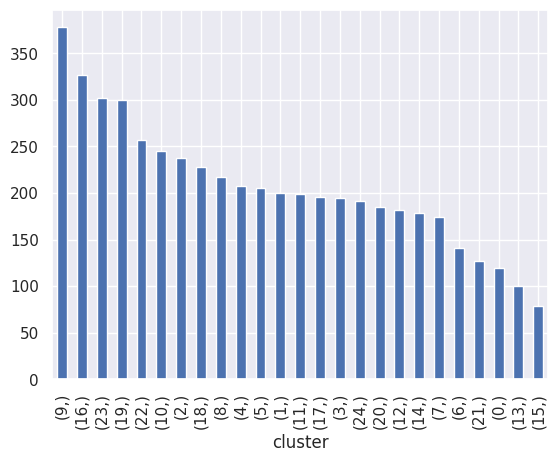

In [16]:
# check cluster distribution
print(clustered_audio_df.value_counts(subset=['cluster']))
clustered_audio_df.value_counts(subset=['cluster']).plot(kind='bar')

In [17]:
pd.DataFrame(clustered_audio_df.value_counts(subset=['cluster'])).mean()

count    206.84
dtype: float64

## Calculating which features are contributing more

In [ ]:
summed_loading_df = get_features_contribution(
    df=audio_df,
    scaler=StandardScaler(),
    normalize=normalize,
    pca=pca,
    pca_comp=pca_comp,
)
summed_loading_df

- instrumentalness: Predicts whether a track contains no vocals.
- valence: A measure from 0.0(sad) to 1.0(happy) describing the musical positiveness conveyed by a track.
- Accousticness→ 1.0 = guitar, drums 0.0 = electronic. Can be very significant to show old vs new
- key *The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.*
- mode: Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- danceability: A value of 0.0 is least danceable and 1.0 is most danceable.
- speechiness: 1.0 a lot talking to 0.0 mostly only music.

In [ ]:
# set threshold for categorizing the songs data
thresholds = {
    'instrumentalness': {
        'lot_vocals': audio_df['instrumentalness'].quantile(0.33),
        'instrumental': audio_df['instrumentalness'].quantile(0.66),
    },
    'valence': {
        'negative': audio_df['valence'].quantile(0.33),
        'positive': audio_df['valence'].quantile(0.66),
    },
    'acousticness': {
        'not_acoustic': audio_df['acousticness'].quantile(0.33),
        'acoustic': audio_df['acousticness'].quantile(0.66),
    },
    'danceability': {
        'not_danceable': audio_df['danceability'].quantile(0.33),
        'danceable': audio_df['danceability'].quantile(0.66),
    },
}

In [ ]:
scaled_audio_df, _ = preprocess_data(
    df=audio_df,
    scaler=StandardScaler(),
    normalize=normalize,
)
scaled_audio_df = scaled_audio_df.merge(clustered_audio_df['cluster'], how='left', left_index=True, right_index=True)
categorized_audio_df = categories_songs(scaled_audio_df, thresholds)

In [ ]:
# create playlists of clusters
spotify_api = SpotifyApi()

In [ ]:
# initialize playlist collection
json_file = pathlib.Path('./playlist_collection.json')
if pathlib.Path.exists(json_file):
    with open(json_file, 'r') as j:
        playlist_collection = json.load(j)
else:
    playlist_collection = {}

In [ ]:
clusters = categorized_audio_df['cluster'].unique()

for cluster in tqdm(clusters):
    playlist_name = create_playlist_name(categorized_audio_df, cluster)
    song_ids = categorized_audio_df.loc[categorized_audio_df['cluster'] == cluster, :].sample(5).index.get_level_values('id')
    if playlist_name in playlist_collection:
        playlist_id = spotify_api.upsert_spotify_playlist(song_ids=song_ids, playlist_id=playlist_collection[playlist_name])
    else:
        playlist_id = spotify_api.upsert_spotify_playlist(song_ids=song_ids, playlist_name=playlist_name)
        playlist_collection[playlist_name] = playlist_id
with open(json_file, "w") as fp:
    json.dump(playlist_collection, fp)